In [375]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
import lasagne
from lasagne.layers import *
import time
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import scipy.stats as st
%matplotlib inline

In [376]:
N = 3000
X = np.random.normal(1,3,(N,2))
noise_x = np.linspace(-10, 10, N) + np.random.random(N)
np.random.shuffle(noise_x)
noise_y = np.linspace(-10, 11, N) + np.random.random(N)
noise = np.column_stack((noise_x, noise_y)) 

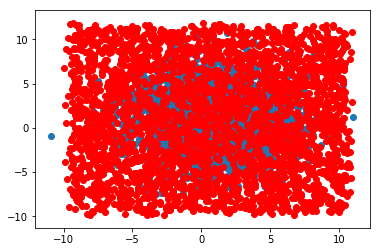

In [377]:
plt.scatter(X[:,0],X[:,1])
plt.scatter(noise[:,0],noise[:,1],color='red')

In [378]:
#GEN NN
input_X = T.matrix()
g_l1 = InputLayer(shape = (None ,2), input_var=input_X)

g_l2 = DenseLayer(g_l1, num_units=40, nonlinearity = lasagne.nonlinearities.leaky_rectify)

g_l3 = DenseLayer(g_l2, num_units=50, nonlinearity = lasagne.nonlinearities.leaky_rectify)

g_l4 = DenseLayer(g_l3, num_units=70, nonlinearity = lasagne.nonlinearities.leaky_rectify)

generator = DenseLayer(g_l4, num_units=2, nonlinearity = None)

g_weights = lasagne.layers.get_all_params(generator)
print (g_weights)

[W, b, W, b, W, b, W, b]


In [379]:
g_generated = lasagne.layers.get_output(generator)
#GEN evaluate
g_eval = theano.function(inputs=[input_X], outputs = g_generated)

In [380]:
# Dicscriminator NN
d_weights = []
d_input = InputLayer(shape = (None ,2), input_var=input_X)
d_l1 = DenseLayer(generator, num_units=50, nonlinearity = lasagne.nonlinearities.leaky_rectify)

d_weights += d_l1.get_params()

d_l2 = DenseLayer(d_l1, num_units=100, nonlinearity = lasagne.nonlinearities.leaky_rectify)

d_weights += d_l2.get_params()

d_l3 = DenseLayer(d_l2, num_units=200, nonlinearity = lasagne.nonlinearities.leaky_rectify)

d_weights += d_l3.get_params()

d_l4 = DenseLayer(d_l3, num_units=50, nonlinearity = lasagne.nonlinearities.leaky_rectify)

d_weights += d_l4.get_params()

d_l5 = DenseLayer(d_l4, num_units=30, nonlinearity = lasagne.nonlinearities.leaky_rectify)

d_weights += d_l5.get_params()

discriminator = DenseLayer(d_l5, num_units=2, nonlinearity = lasagne.nonlinearities.softmax)

d_weights += discriminator.get_params()
print (d_weights)

[W, b, W, b, W, b, W, b, W, b, W, b]


In [381]:
# Loss functions
#Discriminator
d_predicted = lasagne.layers.get_output(discriminator)
d_target = T.matrix()
d_loss = (T.sum(-d_target * T.log(d_predicted),axis = 1)).mean()
#Generator
g_loss = (T.sum(-(1-d_target) * T.log(d_predicted),axis = 1)).mean()

In [382]:
accuracy = lasagne.objectives.categorical_accuracy(d_predicted,d_target).mean()
accuracy_fun = theano.function([input_X,d_target],accuracy)
d_predict = theano.function([input_X],d_predicted)

In [383]:
d_updates_sgd = lasagne.updates.sgd(d_loss, d_weights,learning_rate=0.0001)
g_updates_sgd = lasagne.updates.sgd(g_loss, g_weights,learning_rate=0.0001)

In [384]:
#function that computes loss and updates weights
discriminator_train_fun = theano.function([input_X,d_target],[d_loss,accuracy],updates= d_updates_sgd)
#function that computes loss and updates weights
generator_train_fun = theano.function([input_X,d_target],[g_loss,accuracy],updates= g_updates_sgd)

In [385]:
def iterate_minibatches_discriminator(batchsize):
    
    fake = g_eval(noise)
    inputs = np.vstack((X, fake))
    fake_t = np.array([[1,0] for _ in range(noise.shape[0])])
    X_t = np.array([[0,1] for _ in range(X.shape[0])])
    targets = np.concatenate((fake_t, X_t))
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        excerpt = indices[start_idx:start_idx + batchsize]
        yield inputs[excerpt], targets[excerpt]

In [386]:
def iterate_minibatches_generator(batchsize):
    
    inputs = noise
    targets = np.array([[1,0] for _ in range(inputs.shape[0])])
    
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        excerpt = indices[start_idx:start_idx + batchsize]
        yield inputs[excerpt], targets[excerpt]

In [387]:
def plot_f(x, y ,color,title):

    xy = np.vstack([x,y])
    density = st.gaussian_kde(xy)(xy) 

    idx = density.argsort()
    x, y, density = x[idx], y[idx], density[idx]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, density,color = color )
    plt.title(title)
    plt.show()

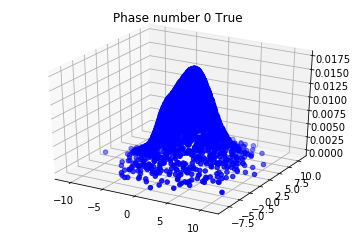

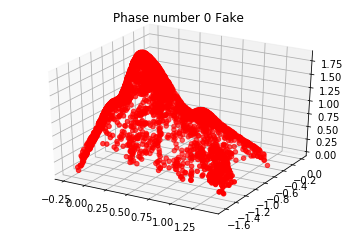

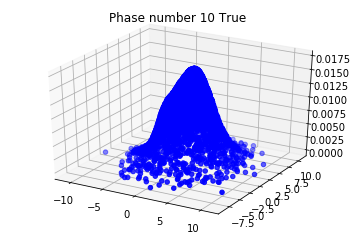

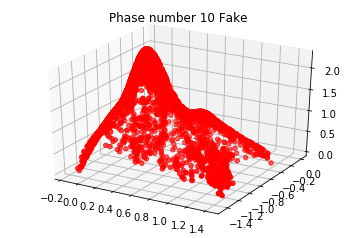

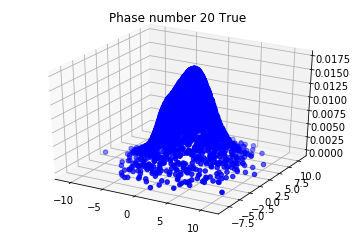

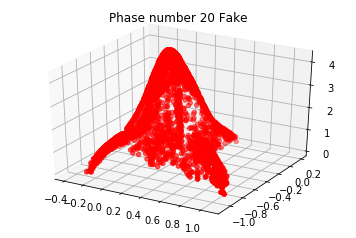

In [388]:
num_epochs = 5 #amount of passes through the data

batch_size = 100 #number of samples processed at each function call

for phase in range(30):

    if phase%10 == 0:
        fake = g_eval(noise)
        plot_f(X[:,0],X[:,1],'blue','Phase number {} True'.format(phase))
        plot_f(fake[:,0],fake[:,1],'red' ,'Phase number {} Fake'.format(phase))
    
    d_l1.input_layer = d_input
    for epoch in range(num_epochs):
    
        train_err = 0
        train_acc = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches_discriminator(batch_size):
            inputs, targets = batch
            discriminator_train_fun(inputs, targets)
    

    d_l1.input_layer = generator
    for epoch in range(num_epochs):
        train_err = 0
        train_acc = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches_generator(batch_size):
            inputs, targets = batch
            generator_train_fun(inputs, targets)

